# 🔁 Quantization in Machine Learning: A Recap

**Quantization** involves reducing the precision of the numerical values (parameters) used in a model, such as weights and biases.

## ❓ What is Quantization?

Most models are trained using 32-bit floating-point numbers (**FP32**).  
Quantization replaces these high-precision values with lower-precision formats like 8-bit integers (**INT8**), significantly reducing the model's memory footprint and computational cost.

---

## 🧠 Conceptual Approaches to Quantization

### 📌 Post-Training Quantization (PTQ)

- Quantize a pre-trained model **without** re-training it.
- Useful when using open-source models (e.g., on Hugging Face).
- Simple and quick to implement.
- May result in a **slight drop in accuracy**.

### 🧠 Quantization-Aware Training (QAT)

- Simulates quantization **during training**, allowing the model to adapt to reduced precision.
- Often results in **better accuracy** than PTQ.
- Requires access to the **training pipeline** and **dataset**.

---

## ⚙️ Practical Quantization Techniques

### 🧩 Method 1: Dynamic Quantization (PyTorch)

- Easy to implement.
- Applied **after training**.
- Works especially well for models with lots of linear layers (like transformers).
- A good balance between performance gains and ease of use.

### 🧪 Method 2: Advanced Quantization (Optimum + ONNX)

- Uses Hugging Face's `optimum` library for **fine-grained**, hardware-optimized quantization.
- Supports backends like **ONNX Runtime**, **Intel Neural Compressor**, etc.
- Slightly more complex setup but offers deeper optimization.

---

## 💡 Use Case: Sentiment Analysis

In this walkthrough, we’ll apply post-training quantization to a **sentiment classification** task (e.g., using BERT or DistilBERT).

### 🤖 Why NLP Models Tolerate Quantization Better Than Vision Models

- NLP models (like transformers) are **heavily linear-layer based**, making them more resilient to quantization without significant accuracy loss.
- Vision models rely more on **convolutional layers** and fine-grained spatial information, where quantization can more easily degrade performance.

---

## 📌 Key Takeaways

- **INT8 models** can be up to **4× smaller** than FP32 versions.
- They can also **run faster** on compatible hardware (like Intel CPUs, NVIDIA TensorRT, etc.).


# Import

In [ ]:
!pip install datasets scikit-learn codecarbon matplotlib seaborn

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.quantization import quantize_dynamic
import torch.nn.functional as F
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from codecarbon import EmissionsTracker
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns

# Experimentation

Before going any further, let's try the model. We are using distilbert-base-uncased-finetuned-sst-2-english, a finetuned version of DistilBERT, specifically trained on the SST-2 dataset for sentiment analysis in English.

In [ ]:
model_name ="distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [3]:
#test using base model
inputs = tokenizer("I love this!", return_tensors="pt")
outputs = model(**inputs)
prediction=F.softmax(outputs.logits,dim=1)
print(prediction)
label = torch.argmax(prediction,dim=1)
print(label)

tensor([[1.2351e-04, 9.9988e-01]], grad_fn=<SoftmaxBackward0>)
tensor([1])


# Quantization with PyTorch


In [4]:
quantized_model = quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

Before we compare them on an evaluation dataset, let's check the model's performance.

In [5]:
outputs = quantized_model(**inputs)
prediction=F.softmax(outputs.logits,dim=1)
print(prediction)
label = torch.argmax(prediction,dim=1)
print(label)

tensor([[1.3575e-04, 9.9986e-01]], grad_fn=<SoftmaxBackward0>)
tensor([1])


## Benchmark

In [6]:
def benchmark_model(model,tokenizer,dataset,batch_size=32):
  """Evaluate model performance on given dataset"""
  model.eval()

  all_preds = []
  all_labels = []
  inference_times = [] #this will be used later to compare them
  carbon_emissions = [] #This also will be used but by default we don't use

  for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset[i:i+batch_size]
    texts = batch['sentence']
    labels = batch['label']

    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    start_time = time.time()
    tracker = EmissionsTracker(save_to_file=False,log_level="off")
    tracker.start()
    with torch.no_grad():
      outputs = model(**inputs)
    emissions = tracker.stop()
    end_time = time.time()
    carbon_emissions.append(emissions)
    inference_times.append(end_time - start_time)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

    all_preds.extend(predictions)
    all_labels.extend(labels)
  accuracy = accuracy_score(all_labels, all_preds)
  precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
  avg_inference_time = sum(inference_times) / len(inference_times)
  avg_carbon_emissions = sum(carbon_emissions) / len(carbon_emissions)
  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'avg_inference_time': avg_inference_time,
      'avg_carbon_emissions': avg_carbon_emissions
  }

In [ ]:
test_dataset = load_dataset("glue", "sst2", split="validation",batch_size=32)

In [ ]:
original_results = benchmark_model(model,tokenizer,test_dataset)

In [ ]:
quantized_results = benchmark_model(quantized_model,tokenizer,test_dataset)

In [10]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'avg_inference_time']
#if you want carbon emissions uncomment the following
metrics.append('avg_carbon_emissions')

In [11]:
original_values = [original_results[m] for m in metrics]
quantized_values = [quantized_results[m] for m in metrics]

In [12]:
# Save both models
torch.save(model.state_dict(), "original_model.pt")
torch.save(quantized_model.state_dict(), "quantized_model.pt")

original_model_size =  os.path.getsize("original_model.pt") / 1e6
quantized_model_size = os.path.getsize("quantized_model.pt") / 1e6

In [13]:
original_values.append(original_model_size)
quantized_values.append(quantized_model_size)
metrics.append("model size")

In [16]:
df = pd.DataFrame({
    'Metric': metrics,
    'Original Model': original_values,
    'Quantized Model': quantized_values
})

# Comparaison

In [17]:
df.head(7)

,Metric,Original Model,Quantized Model
0,accuracy,0.910550,0.897936
1,precision,0.911045,0.898772
2,recall,0.910550,0.897936
3,f1,0.910490,0.897831
4,avg_inference_time,3.195060,2.603668
5,avg_carbon_emissions,0.000013,0.000008
6,model size,267.860822,138.715658


In [18]:
def plot_model_comparison(df):
    """
    Function that displays 4 charts comparing the original model and the quantized model:
    1. Comparison of performance metrics (accuracy, precision, recall, f1)
    2. Comparison of model size
    3. Comparison of inference time
    4. Comparison of CO2 emissions

    Args:
        df: DataFrame containing the metrics of the models
    """

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparison between Original Model and Quantized Model', fontsize=16)


    colors = ['#3498db', '#e74c3c']  # Blue for original, Red for quantized

    # 1. Chart to compare performance metrics
    performance_metrics = ['accuracy', 'precision', 'recall', 'f1']
    values_original = df.loc[df.index.isin(range(4)), 'Original Model'].values
    values_quantized = df.loc[df.index.isin(range(4)), 'Quantized Model'].values

    x = np.arange(len(performance_metrics))
    width = 0.35

    axes[0, 0].bar(x - width/2, values_original, width, color=colors[0], label='Original Model')
    axes[0, 0].bar(x + width/2, values_quantized, width, color=colors[1], label='Quantized Model')
    axes[0, 0].set_title('Performance Metrics')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(performance_metrics)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Chart to compare model size
    sizes = [df.loc[6, 'Original Model'], df.loc[6, 'Quantized Model']]
    models = ['Original Model', 'Quantized Model']

    axes[0, 1].bar(models, sizes, color=colors)
    axes[0, 1].set_title('Model Size (MB)')
    axes[0, 1].set_ylabel('Size (MB)')
    for i, v in enumerate(sizes):
        axes[0, 1].text(i, v + 5, f"{v:.2f} MB", ha='center')
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # 3. Chart to compare inference time
    inference_times = [df.loc[4, 'Original Model'], df.loc[4, 'Quantized Model']]

    axes[1, 0].bar(models, inference_times, color=colors)
    axes[1, 0].set_title('Average Inference Time')
    axes[1, 0].set_ylabel('Time (seconds)')
    for i, v in enumerate(inference_times):
        axes[1, 0].text(i, v + 0.05, f"{v:.4f} s", ha='center')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # 4. Chart to compare CO2 emissions
    emissions = [df.loc[5, 'Original Model'], df.loc[5, 'Quantized Model']]

    axes[1, 1].bar(models, emissions, color=colors)
    axes[1, 1].set_title('Average CO2 Emissions')
    axes[1, 1].set_ylabel('Emissions (kg)')
    for i, v in enumerate(emissions):
        axes[1, 1].text(i, v + 0.0000005, f"{v:.8f} kg", ha='center')
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


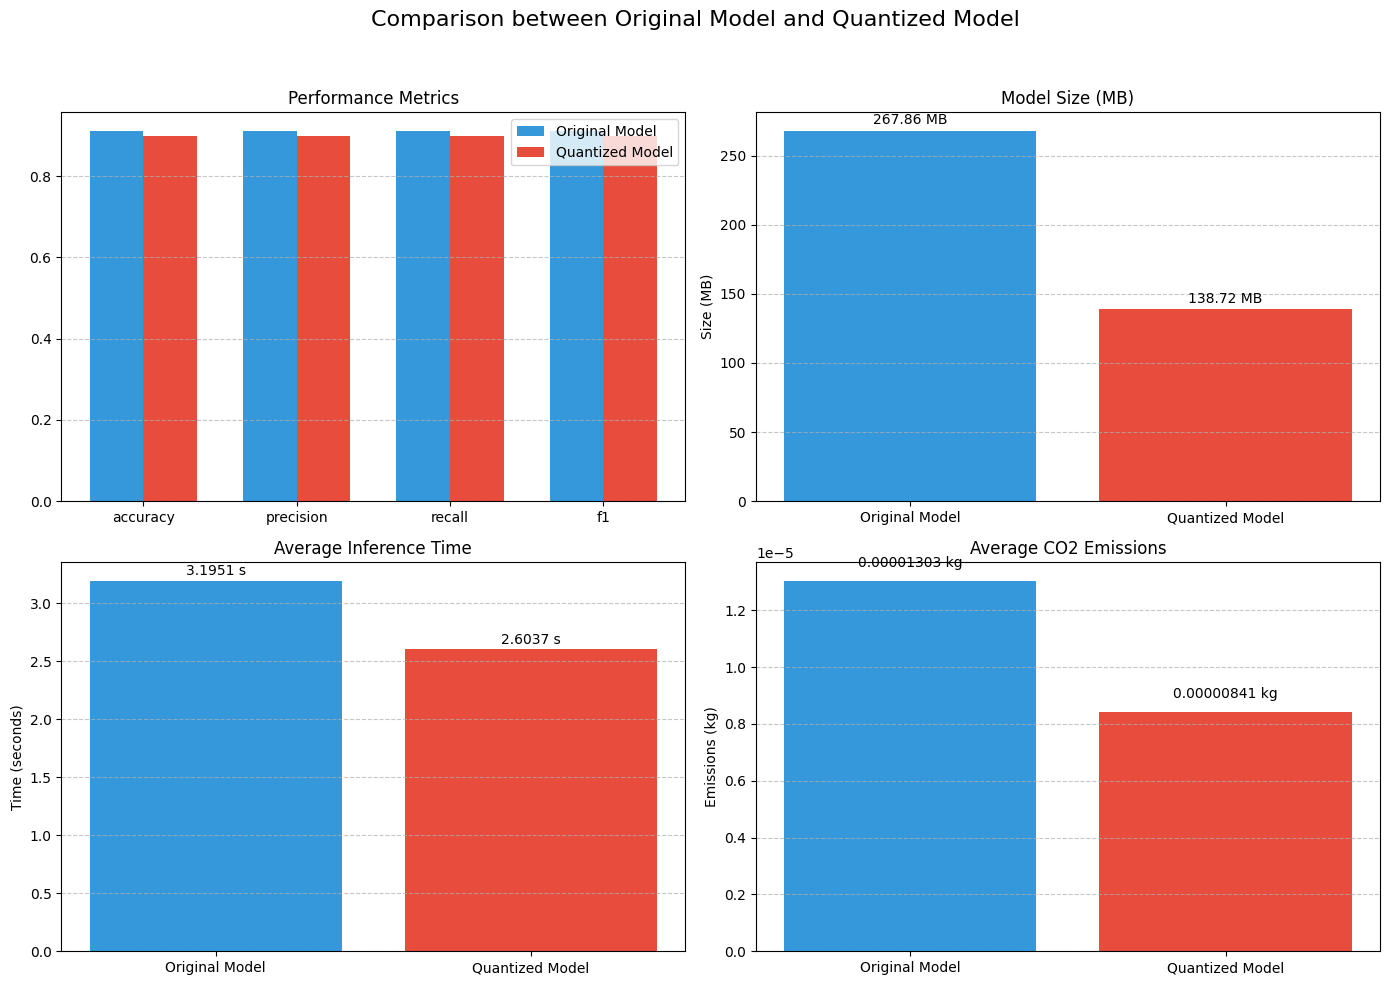

In [19]:
plot_model_comparison(df)

#

In [23]:
def show_quantization_errors(model_orig, model_quant, tokenizer, dataset, n=5):

    model_orig.eval()
    model_quant.eval()

    errors = []
    for sample in dataset:
        text = sample["sentence"]
        true_label = sample["label"]

        inputs = tokenizer(text, return_tensors="pt")

        with torch.no_grad():
            pred_orig = torch.argmax(F.softmax(model_orig(**inputs).logits, dim=1), dim=1).item()
            pred_quant = torch.argmax(F.softmax(model_quant(**inputs).logits, dim=1), dim=1).item()

        if pred_orig == true_label and pred_quant != true_label:
            errors.append({
                "text": text,
                "true_label": true_label,
                "quant_pred": pred_quant,
                "orig_pred": pred_orig
            })

        if len(errors) >= n:
            break

    for i, err in enumerate(errors):
        print(f"--- Example {i+1} ---")
        print(f"Text         : {err['text']}")
        print(f"True Label   : {err['true_label']}")
        print(f"Quantized Prediction: {err['quant_pred']}")
        print(f"Original Prediction : {err['orig_pred']}")
        print()


show_quantization_errors(model, quantized_model, tokenizer, test_dataset)


--- Example 1 ---
Text         : if the movie succeeds in instilling a wary sense of ` there but for the grace of god , ' it is far too self-conscious to draw you deeply into its world . 
True Label   : 0
Quantized Prediction: 1
Original Prediction : 0

--- Example 2 ---
Text         : it 's one pussy-ass world when even killer-thrillers revolve around group therapy sessions . 
True Label   : 0
Quantized Prediction: 1
Original Prediction : 0

--- Example 3 ---
Text         : delivers the same old same old , tarted up with latin flava and turned out by hollywood playas . 
True Label   : 0
Quantized Prediction: 1
Original Prediction : 0

--- Example 4 ---
Text         : the format gets used best ... to capture the dizzying heights achieved by motocross and bmx riders , whose balletic hotdogging occasionally ends in bone-crushing screwups . 
True Label   : 1
Quantized Prediction: 0
Original Prediction : 1

--- Example 5 ---
Text         : all that 's missing is the spontaneity , originali

The quantized model significantly reduces model size (≈48% smaller) and inference time, while also lowering CO₂ emissions during execution. Despite these advantages, a slight drop in performance is observed, particularly in nuanced sentiment cases.

🔍 Error Analysis Insights
The following examples show where the quantized model misclassified the sentiment while the original model succeeded:

The quantized model tends to misinterpret sarcasm or subtle negative expressions as positive.

Complex sentence structures or ambiguous tones seem to be harder for the compressed model to handle.

This suggests that quantization can affect the model's sensitivity to linguistic nuances, particularly in edge cases.

➡️ Takeaway: Quantization offers great practical benefits, but depending on the application, especially in sentiment analysis, some interpretability and subtle semantic understanding may be lost.